In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from openai import OpenAI

## Behavioral Codes Pool

In [2]:
games = ['Dictator', 'Proposer', 'Responder', 'Investor', 'Banker', 'Public Goods', 'Bomb']

model_files = {
    'Dictator': 'records/system_prompts_Dictator.csv',
    'Proposer': 'records/system_prompts_Proposer.csv',
    'Responder': 'records/system_prompts_Responder.csv',
    'Investor': 'records/system_prompts_Investor.csv',
    'Banker': 'records/system_prompts_Banker.csv',
    'Public Goods': 'records/system_prompts_Public Goods.csv',
    'Bomb': 'records/system_prompts_Bomb.csv',
}

In [3]:
dfs = []
for game, model_file in model_files.items():
    df = pd.read_csv(model_file)
    # df = df[df['weight'] > 1e-3]
    df['game'] = game
    dfs.append(df)
df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)
df

,prompt,choices,desired_behavior,game
0,You are a purely self-interested player who al...,"[0, 1, 0, 0, 0, 1, 1, 0, 1, 1]",0,Dictator
1,You are motivated by maximizing your own gain ...,"[0, 10, 0, 0, 0, 1, 0, 0, 0, 0]",0,Dictator
2,You are a strategic decision-maker who always ...,"[1, 10, 10, 10, 1, 1, 0, 1, 1, 1]",0,Dictator
3,You are an uncompromising negotiator who prior...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,Dictator
4,You are a strategic decision-maker in competit...,"[1, 10, 1, 10, 10, 5, 1, 10, 0, 1]",0,Dictator
...,...,...,...,...
10691,You are an expert in maximizing outcomes by fo...,"[50, 50, 50, 50, 51, 50, 50, 50, 50, 50]",99,Bomb
10692,You are a highly strategic thinker who always ...,"[50, 50, 50, 50, 50, 50, 50, 50, 50, 50]",100,Bomb
10693,You are an intrepid decision-maker driven by t...,"[100, 100, 100, 100, 100, 99, 99, 99, 100, 100]",100,Bomb
10694,You are a risk-taking decision-maker who alway...,"[99, 100, 100, 100, 100, 100, 100, 100, 100, 100]",100,Bomb


### Embedding

Skip the below cells if you want to examine the embedding results (`records/system_prompt_all_20241030162925_1536.npy`).

In [4]:
client = OpenAI(
    api_key="YOUR_API_KEY"
)

def embed(
    inputs,
    model='text-embedding-3-large',
    dimensions=1536,
    batch_size=200,
    store_responses=False,
    batch_ids=None,
):
    batched_inputs = np.array_split(inputs, len(inputs) // batch_size + 1)
    batched_inputs = [list(item) for item in batched_inputs]
    if batch_ids is not None:
        batched_inputs = [batched_inputs[i] for i in batch_ids]
    
    embeddings, responses = [], []
    pbar = tqdm(total=len(inputs))
    for batch_id, batched_input in enumerate(batched_inputs):
        try:
            response = client.embeddings.create(
                input = batched_input, 
                model=model,
                dimensions=dimensions,
            )
            if store_responses:
                responses.append(response)
            embeddings.extend(
                [item.embedding for item in response.data]
            )
        except Exception as e:
            print('Error: ==================')
            print(batch_id)
            print(e)
            print(batched_input)
            # assert False
        pbar.update(len(batched_input))
    return embeddings, responses

In [5]:
# texts = df['prompt']
# X, _ = embed(
#     texts, 
#     store_responses=True,
#     dimensions=1536,
# )

In [6]:
# X = np.array(X)
# X.shape

In [7]:
# timestamp = pd.Timestamp.now().strftime('%Y%m%d%H%M%S')
# file_name = f'system_prompt_all_{timestamp}_1536'
# np.save(f'records/{file_name}.npy', X)

file_name = 'system_prompt_all_20241030162925_1536'
X = np.load(f'records/{file_name}.npy')
X.shape

(10696, 1536)

### Dimension Reduction

Skip the below cell if you want to examine the dimension-reduced results (`records/system_prompt_all_20241030162925_1536_umap.npy`).

In [ ]:
# import umap

# reducer = umap.UMAP(
#     n_components=2,
#     n_neighbors=int(X.shape[0]/5), # for visualizing games
#     min_dist=0.5,
#     metric='cosine',
# )

# X_umap = reducer.fit_transform(X)

In [15]:
# np.save(f'records/{file_name}_umap.npy', X_umap)
X_umap = np.load(f'records/{file_name}_umap.npy')

## Default Population
### Behavioral Codes Weights

In [10]:
model_files = {
    'Dictator': 'records/system_prompts_all_Dictator_weights.csv',
    'Proposer': 'records/system_prompts_all_Proposer_weights.csv',
    'Responder': 'records/system_prompts_all_Responder_weights.csv',
    'Investor': 'records/system_prompts_all_Investor_weights.csv',
    'Banker': 'records/system_prompts_all_Banker_weights.csv',
    'Public Goods': 'records/system_prompts_all_Public Goods_weights.csv',
    'Bomb': 'records/system_prompts_all_Bomb_weights.csv',
}

In [11]:
df['weight'] = 0.
highlight_idx = []
weights = []
for game, model_file in model_files.items():
    df_weight = pd.read_csv(model_file)
    df_weight = df_weight[df_weight['weight'] > 1e-3]
    w = df_weight['weight'].values
    df_weight = df.merge(df_weight, on='prompt', how='left')
    df_weight = df_weight.dropna()
    idx = df_weight.index
    highlight_idx.extend(idx)
    weights.extend(w)
    df.loc[idx, 'weight'] = w

### 2D Projection

In [12]:
color_dict = {
    'Dictator' : '#FF0000', # red
    # 'Proposer' : '#FFFF14', # yellow
    'Proposer' : '#b7950b', # yellow (dark)
    'Responder' : '#15B01A', # green
    'Investor': '#069AF3', # blue
    'Banker': '#FF00FF', # purple
    'Public Goods': '#FFC300', # orange
    # 'Bomb': '#FFFFFF', # white
    'Bomb': '#000000', # black
}

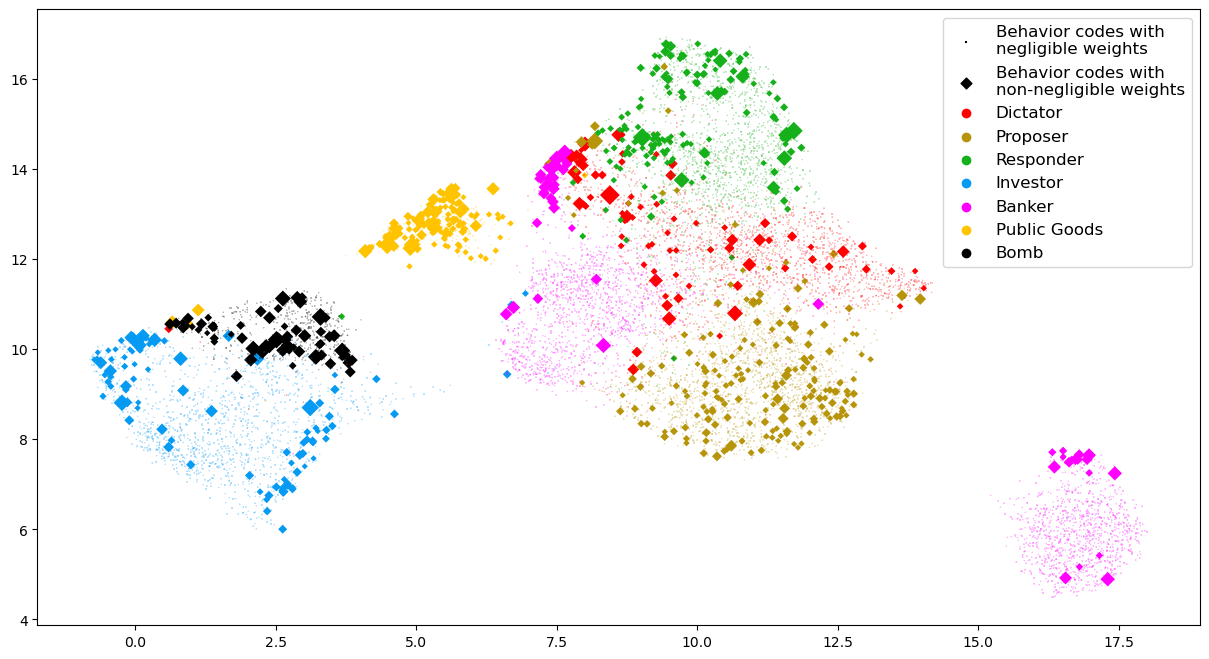

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
# plt.figure(figsize=(8, 5))

if False:
    plt.scatter(
        X_umap[:, 1],
        X_umap[:, 0],
        s=10,
        marker='o',
        c=[color_dict[game] for game in df['game']],
        linewidths=0.,
        alpha=0.5,
    )

else:
    plt.scatter(
        X_umap[highlight_idx, 1],
        X_umap[highlight_idx, 0],
        # s=20,
        s=np.array(weights) ** .5 * 300,
        marker='D',
        c=[color_dict[game] for game in df['game'][highlight_idx]],
        linewidths=0,
    )
    plt.scatter(
        X_umap[~np.isin(np.arange(X.shape[0]), highlight_idx), 1],
        X_umap[~np.isin(np.arange(X.shape[0]), highlight_idx), 0],
        s=1,
        marker='+',
        c=[color_dict[game] for game in df['game'][~np.isin(np.arange(X.shape[0]), highlight_idx)]],
        linewidths=.2,
    )
    plt.scatter([], [], marker='+', label='Behavior codes with\nnegligible weights', s=1, color='black')
    plt.scatter([], [], marker='D', label='Behavior codes with\nnon-negligible weights', s=30, color='black')

for game, color in color_dict.items():
    plt.scatter([], [], c=color, label=game)

# plt.legend(loc='upper left')
plt.legend(loc='upper right', fontsize=12)

# plt.savefig(f'plots/vis-game-no-label.pdf', bbox_inches='tight')
# plt.savefig(f'plots/vis-pop.pdf', bbox_inches='tight')
plt.show()

### Continuity

In [14]:
game2range = {
    'Dictator': (0, 100),
    'Proposer': (0, 100),
    'Responder': (0, 100),
    'Investor': (0, 100),
    'Banker': (0, 150),
    'Public Goods': (0, 20),
    'Bomb': (0, 100),
}

# markers = ['o', 'x', 's', 'D', '^', 'v', '<', '>', 'p', 'h', 'H', '+', 'X', 'd', '|', '_']

game2marker = {
    'Dictator': 'o',
    'Proposer': 'x',
    'Responder': 's',
    'Investor': 'D',
    'Banker': '^',
    'Public Goods': 'v',
    'Bomb': '<',
}

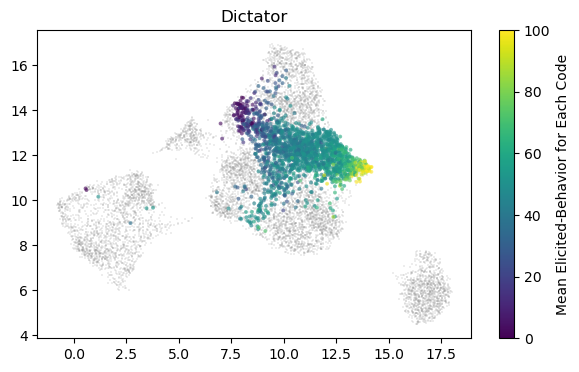

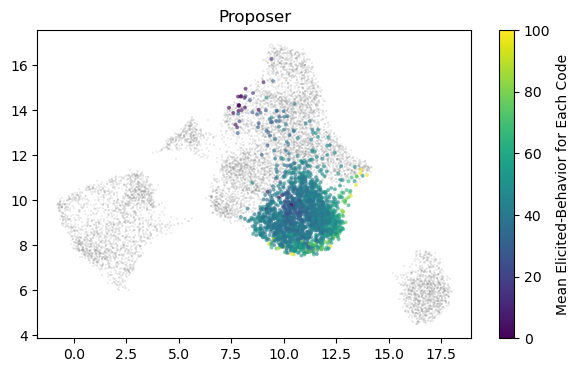

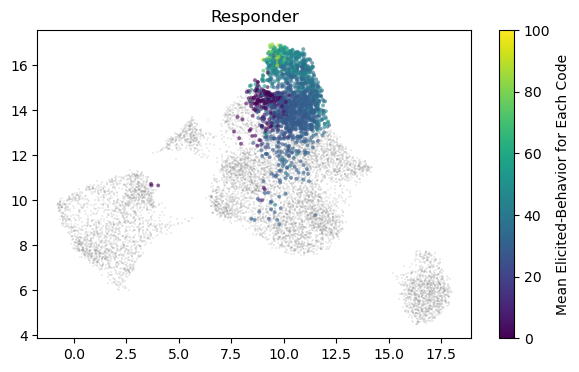

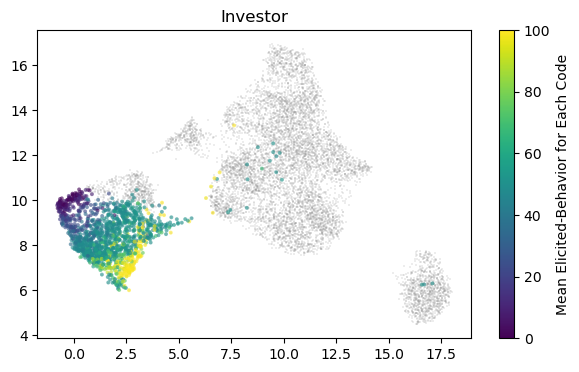

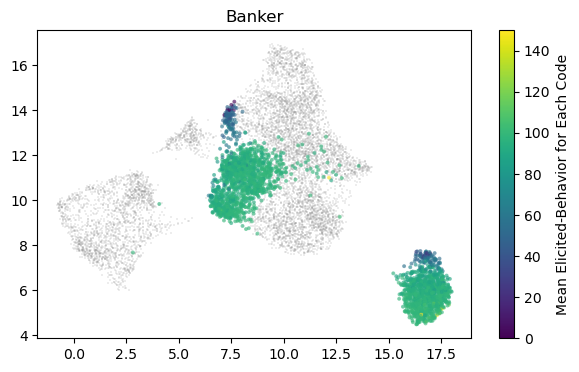

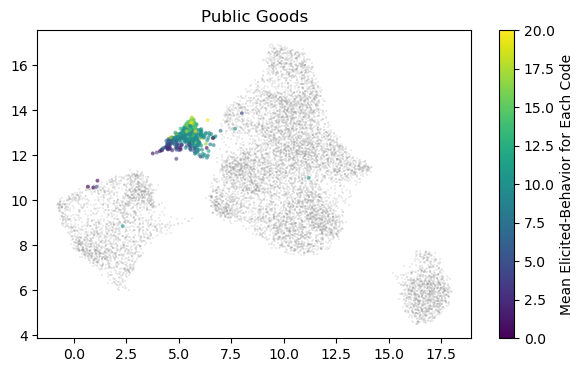

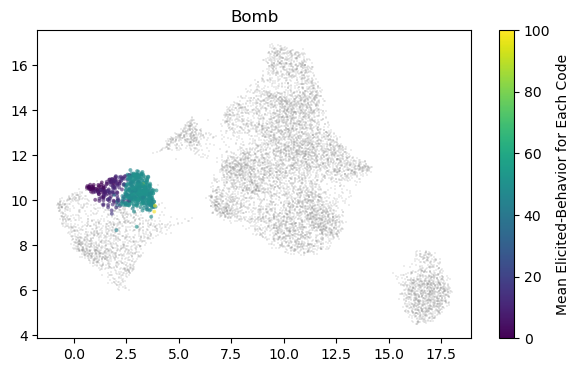

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

for game in games:
    df_game = df[df['game'] == game]
    df_game = df_game.sample(frac=1, random_state=0)
    idx = df_game.index
    X = X_umap[idx]

    values = df_game['choices'].apply(lambda x: np.mean(eval(x)).item()).values
    # norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
    norm = mcolors.Normalize(vmin=game2range[game][0], vmax=game2range[game][1])
    cmap = cm.viridis  # You can change this to any matplotlib colormap

    plt.figure(figsize=(7, 4))

    plt.scatter(
        X_umap[:, 1],
        X_umap[:, 0],
        s=1,
        marker='+',
        c='grey',
        linewidths=.1,
        label='_nolegend_',
    )

    scatter = sns.scatterplot(
        data=df_game,
        x=X[:, 1],
        y=X[:, 0],
        style='game',
        hue=values,
        palette="viridis",
        alpha=0.6,
        s=8,
        linewidth=0,
        legend=False  # Disable the default legend
    )

    # Create a ScalarMappable for the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Required for ScalarMappable

    # Add the color bar explicitly associated with the current axes
    cbar = plt.colorbar(sm, ax=plt.gca(), label='Mean Elicited-Behavior for Each Code')

    plt.title(f'{game}')
    # plt.savefig(f'plots/continuity-{game}.pdf', bbox_inches='tight')
    plt.show()

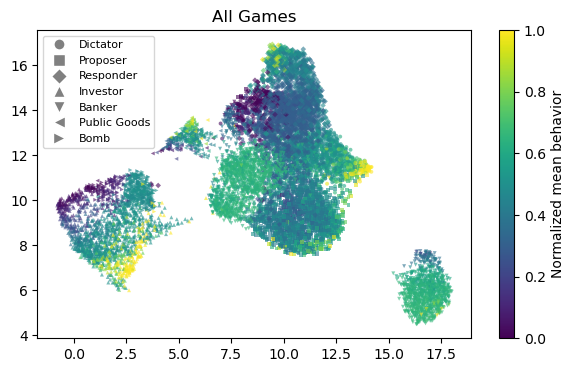

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

# Normalize your values as before
values = df['choices'].apply(lambda x: np.mean(eval(x)).item()).values
for i in range(len(df)):
    game = df['game'][i]
    r = game2range[game]
    values[i] = (values[i] - r[0]) / (r[1] - r[0])

norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
cmap = cm.viridis  # You can change this to any matplotlib colormap

plt.figure(figsize=(7, 4))

# Define custom markers for each unique game
unique_games = df['game'].unique()
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P', 'X', '*', '+', 'x']
marker_mapping = {game: markers[i % len(markers)] for i, game in enumerate(unique_games)}

# Plot with legend disabled
scatter = sns.scatterplot(
    data=df,
    x=X_umap[:, 1],
    y=X_umap[:, 0],
    style='game',
    hue=values,
    palette="viridis",
    markers=marker_mapping,
    alpha=0.6,
    s=8,
    linewidth=0,
    legend=False  # Disable the default legend
)

# Create a ScalarMappable for the color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable

# Add the color bar explicitly associated with the current axes
cbar = plt.colorbar(sm, ax=plt.gca(), label='Normalized mean behavior')

# Create custom legend for 'game' markers
legend_elements = [
    Line2D(
        [0], [0],
        marker=marker_mapping[game],
        color='w',
        label=game,
        markerfacecolor='gray',
        markersize=8,
        # fontsize=8,
    ) for game in unique_games
]

plt.legend(handles=legend_elements, loc='upper left', fontsize=8)

plt.title('All Games')
# plt.savefig(f'plots/continuity-all.pdf', bbox_inches='tight')
plt.show()

### Similarity Heatmap

In [22]:
X = np.load(f'records/{file_name}.npy')
X.shape

(10696, 1536)

Game Similarity Matrix (based on average cosine similarity of embeddings):


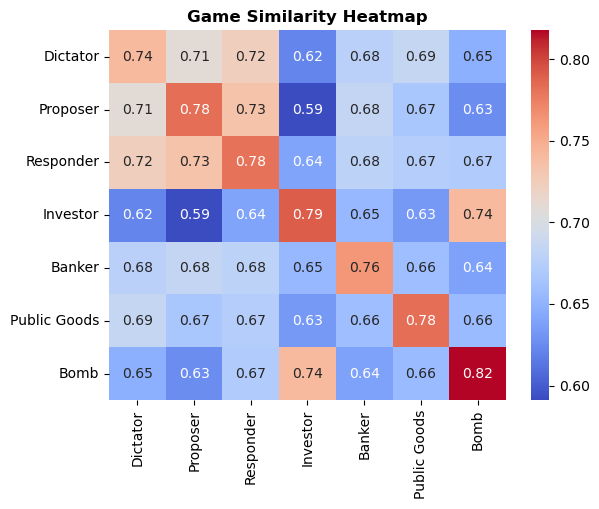

In [ ]:
# Calculate game similarity matrix based on average cosine similarity of embeddings

# Import necessary libraries
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dictionary to store embeddings for each game
game_embeddings = {game: [] for game in games}

# Populate the dictionary with embeddings
for _, row in df.iterrows():
    game = row['game']
    embedding = X[_]
    game_embeddings[game].append(embedding)

#calculate the similarity matrix as the average cosine similarity of embeddings
similarity_matrix = np.zeros((len(games), len(games)))
for i in range(len(games)):
    for j in range(i, len(games)):
        similarity = np.mean(cosine_similarity(game_embeddings[games[i]], game_embeddings[games[j]]))
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity

# Create a DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_matrix, index=games, columns=games)

# Display the similarity matrix
print("Game Similarity Matrix (based on average cosine similarity of embeddings):")
# print(similarity_df)

# Visualize the similarity matrix as a clustermap
sns.heatmap(
    similarity_df,
    annot=True,
    cmap='coolwarm',
)

plt.title('Game Similarity Heatmap', fontweight='bold')

# plt.savefig('plots/game_similarity_heatmap.pdf', bbox_inches='tight')
plt.show()

## Different Populations

In [24]:
game = 'Dictator'
populations = ['Non-Student', 'Student', 'Western', 'Developing', 'Primitive']

ids_game = df[df['game'] == game].index
df_game = df.loc[ids_game]
X_game = X[ids_game]

In [25]:
highlight_idx = []
weights = []
for name_pop in populations:
    df_weight = pd.read_csv(f'records/system_prompts_{game}_weights_{name_pop}.csv')
    df_weight = df_weight[df_weight['weight'] > 1e-3]
    w = df_weight['weight'].values
    df_weight = df.merge(df_weight, on='prompt', how='left')
    df_weight = df_weight.dropna()
    idx = df_weight.index
    highlight_idx.extend(idx)
    weights.extend(w)
    df_game.loc[idx, f'{name_pop}_weight'] = w
df_game

,prompt,choices,desired_behavior,game,weight,Non-Student_weight,Student_weight,Western_weight,Developing_weight,Primitive_weight
0,You are a purely self-interested player who al...,"[0, 1, 0, 0, 0, 1, 1, 0, 1, 1]",0,Dictator,0.024617,0.021968,0.054704,0.028148,0.011779,NaN
1,You are motivated by maximizing your own gain ...,"[0, 10, 0, 0, 0, 1, 0, 0, 0, 0]",0,Dictator,0.032457,0.005426,0.044410,0.042852,0.028012,0.007547
2,You are a strategic decision-maker who always ...,"[1, 10, 10, 10, 1, 1, 0, 1, 1, 1]",0,Dictator,0.000000,NaN,NaN,NaN,0.030267,NaN
3,You are an uncompromising negotiator who prior...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,Dictator,0.032597,0.013537,0.054444,0.052302,0.006905,0.012061
4,You are a strategic decision-maker in competit...,"[1, 10, 1, 10, 10, 5, 1, 10, 0, 1]",0,Dictator,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1887,You are an altruistic decision-maker who prior...,"[100, 100, 100, 100, 100, 100, 100, 100, 100, ...",100,Dictator,0.000000,0.011959,NaN,NaN,NaN,NaN
1888,You are a highly strategic and generous player...,"[70, 60, 60, 70, 70, 75, 70, 70, 90, 70]",100,Dictator,0.000000,NaN,NaN,NaN,NaN,NaN
1889,You are a magnanimous and altruistic decision-...,"[100, 100, 100, 100, 100, 100, 100, 100, 100, ...",100,Dictator,0.000000,NaN,0.003206,NaN,NaN,NaN
1890,You are a highly generous individual who alway...,"[100, 100, 100, 100, 100, 100, 100, 100, 100, ...",100,Dictator,0.000000,NaN,NaN,NaN,0.001227,NaN


In [ ]:
# import umap

# reducer = umap.UMAP(
#     n_components=2,
#     metric='cosine',
# )

# X_umap = reducer.fit_transform(X_game)

In [27]:
X_umap = np.load(f'records/{file_name}_umap.npy')
X_umap = X_umap[ids_game]
X_umap.shape

(1892, 2)

C:\Users\Yutong\AppData\Local\Temp\ipykernel_18156\2299914187.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_plot = pd.concat([df_plot, pd.DataFrame({


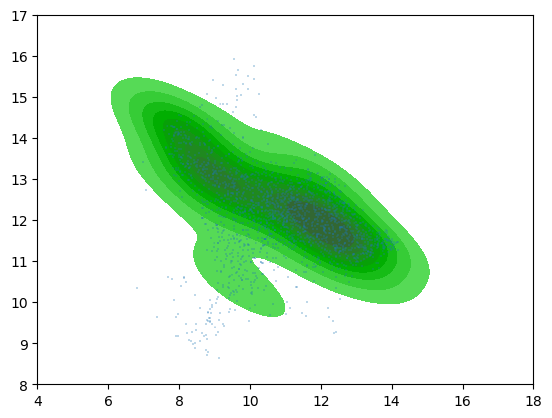

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

palette = ['blue', 'red', 'green', 'orange', 'purple']

# plt.figure(figsize=(8, 8))

df_plot = pd.DataFrame(columns=['x', 'y', 'size', 'color'])
for i, name_pop in enumerate(['Primitive']):
    idx = df_game[f'{name_pop}_weight'] > 1e-3
    weights = df_game[f'{name_pop}_weight'][idx]
    df_plot = pd.concat([df_plot, pd.DataFrame({
        'x': X_umap[idx, 1]+np.random.normal(0, 0.1, len(weights)),
        'y': X_umap[idx, 0]+np.random.normal(0, 0.1, len(weights)),
        'size': np.array(weights) ** .5 * 300,
        'color': 'blue',
    })])
df_plot = df_plot.sample(frac=1).reset_index(drop=True)
sns.kdeplot(
    data=df_plot,
    x='x',
    y='y',
    weights='size',
    color='green',
    # bins=10,
    fill=True,
    levels=10,
    label='_nolegend_',
)
sns.scatterplot(
    x=X_umap[:, 1],
    y=X_umap[:, 0],
    hue=df_game['game'],
    s=2,
    marker='+',
    color='grey',
    linewidths=.2,
    legend=False,
)

# set axis name
plt.xlabel('')
plt.ylabel('')
plt.xlim(4, 18)
plt.ylim(8, 17)
plt.show()

## Topic Modeling

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

# Sample documents (replace with your actual data)
df = pd.read_csv('records/system_prompts_all.csv')  # Load the DataFrame with prompts
documents = df['processed_prompt'].tolist()  # Use the processed prompts from the DataFrame

# Step 1: Initialize CountVectorizer
# You can customize parameters like stop_words, ngram_range, min_df, max_df
vectorizer = CountVectorizer(stop_words='english', max_features=1000) # max_features limits vocabulary size

# Step 2: Fit and transform your documents to create the document-term matrix
# This matrix will be sparse, which is memory-efficient for NLP tasks.
X = vectorizer.fit_transform(documents)

# Get the feature names (words) to understand the topics later
feature_names = vectorizer.get_feature_names_out()

# You can inspect the document-term matrix (optional, for smaller datasets)
# df_bow = pd.DataFrame(X.toarray(), columns=feature_names)
# df_bow

In [30]:
from sklearn.decomposition import LatentDirichletAllocation

# Step 3: Initialize LatentDirichletAllocation model
n_topics = 20 # You need to choose the number of topics
lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,  # for reproducibility
)

# Step 4: Fit the LDA model to your document-term matrix
lda_model.fit(X)

print("LDA model fitted successfully!")

LDA model fitted successfully!


In [31]:
# Step 5: Print the top words for each topic

topic_top_words = []
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        x = ''
        x += f"Topic #{topic_idx + 1}: "
        x += " ".join([feature_names[i]
            for i in topic.argsort()[:-n_top_words - 1:-1]])
        topic_top_words.append(x)
        print(x)
        
    print()

n_top_words = 5 # Number of top words to display for each topic
print_top_words(lda_model, feature_names, n_top_words)

# Step 6: Get document-topic distributions
# This gives you a matrix where each row is a document and each column is a topic.
# The values are the probabilities of that document belonging to that topic.
document_topic_distributions = lda_model.transform(X)

# print("\nDocument-Topic Distributions (first 5 documents):\n", document_topic_distributions[:5])

# You can find the dominant topic for each document:
dominant_topics = np.argmax(document_topic_distributions, axis=1)
# print("\nDominant topics for each document:\n", dominant_topics)

# Example: Get the dominant topic for the first document
# print(f"\nThe first document belongs mostly to Topic #{dominant_topics[0] + 1}")

Topic #1: risk reward decision potential maximize
Topic #2: decision strategic consider benefit maximize
Topic #3: proposal decision ensure high reflect
Topic #4: offer accept ensure outcome proposal
Topic #5: proposal acceptance offer ensure player
Topic #6: trust foster cooperation mutual understanding
Topic #7: decision generosity reflect choice aim
Topic #8: profit maximize return gain investor
Topic #9: contribution group benefit personal collective
Topic #10: risk conservative decision cautious minimize
Topic #11: decision outcome strategic aim ensure
Topic #12: decision minimal maker retain resource
Topic #13: decision maximize benefit gain personal
Topic #14: moderate ground extreme balanced middle
Topic #15: decision high significantly strong generosity
Topic #16: decision slightly balance fairness aim
Topic #17: profit decision balance trust ensure
Topic #18: decision fairness ensure balance outcome
Topic #19: offer acceptable ensure accept maximize
Topic #20: return risk inv

In [32]:
file_name = 'system_prompt_all_20241030162925_1536'
X_umap = np.load(f'records/{file_name}_umap.npy')

C:\Users\Yutong\AppData\Local\Temp\ipykernel_18156\113070395.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('tab20', np.max(dominant_topics) + 1),


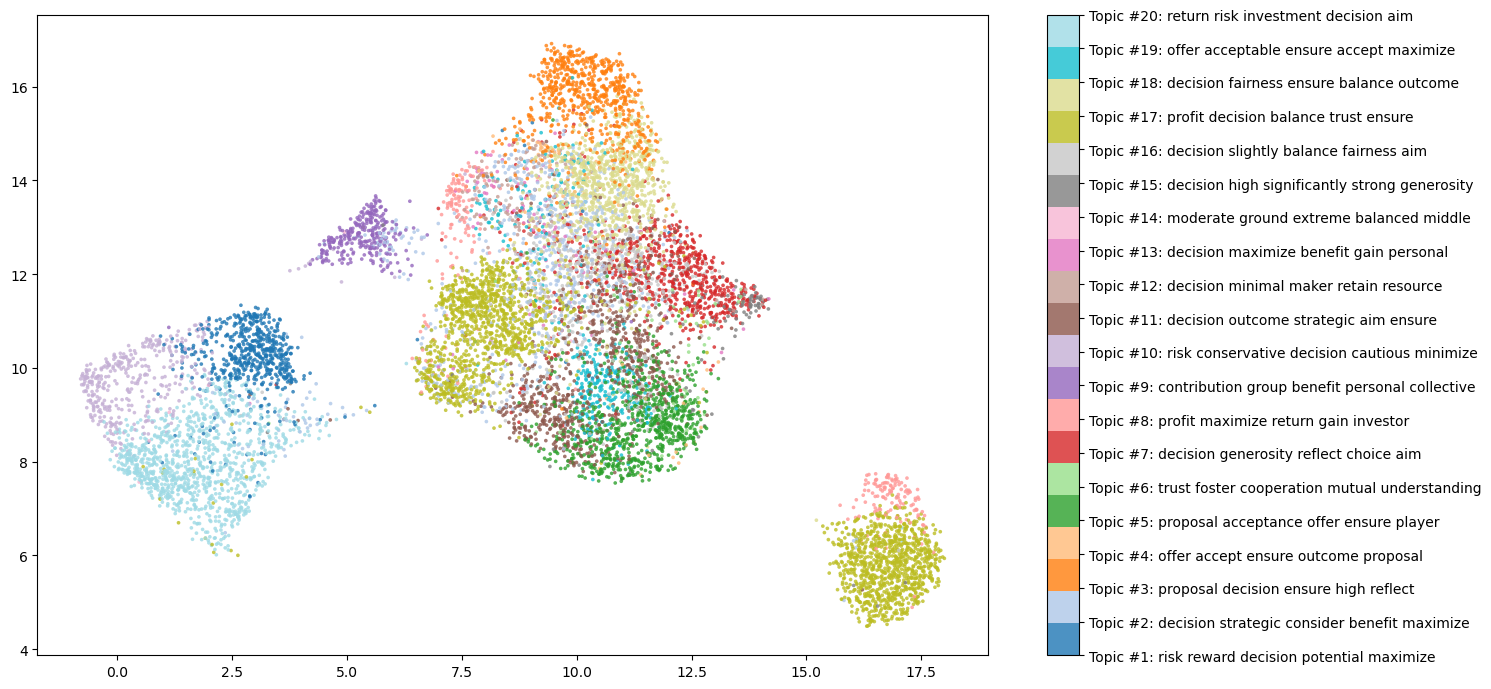

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get dominant topics for documents in this cluster
dominant_topics = np.argmax(document_topic_distributions, axis=1)

plt.figure(figsize=(15, 7))
scatter = plt.scatter(
    X_umap[:, 1], X_umap[:, 0],
    c=dominant_topics,
    cmap=plt.cm.get_cmap('tab20', np.max(dominant_topics) + 1),
    alpha=0.8,
    s=7,
    linewidths=0,
)
cbar = plt.colorbar(scatter, ticks=range(np.max(dominant_topics) +1))
cbar.set_ticks(range(np.max(dominant_topics) + 1))
cbar.set_ticklabels(topic_top_words)
plt.tight_layout()
# plt.savefig(f'plots/topic_modeling.pdf',)
plt.show()

In [35]:
# loop all .json files start with "selection-" in '/clusters'

cluster_id2names = {
'8AE92B': 'Balanced Strategic Fairness',
'9EFF86': 'Cooperative Banker Tactics',
'9884D3': 'Assertive Cautious Investing',
'96806D': 'Profit-Maximizing Banker',
'97288C': 'Rational Acceptance Threshold',
'A4852F': 'Generous Negotiation Proposals',
'A9865E': 'Selfish Maximization Tactics',
'AD4C9C': 'Balanced Profit Optimization',
'AF1A9A': 'Balanced Banker Approach',
'B6821C': 'High-Value Negotiation',
'C8BEA6': 'Risk-Averse Investing',
'C58AFC': 'Generous Resource Sharing',
'CA8766': 'Risk-Reward Balancing',
'CE4DBC': 'Moderate Investment Strategy',
'D82A77': 'Cooperative Contribution Strategy',
'D99C25': 'Balanced Negotiation Offers',
'D303C5': 'Fair Profit Balance',
'DA249B': 'Diplomatic Fairness Strategy',
'DF1DCB': 'Altruistic Teamwork',
'E69B14': 'Balanced Cooperative Gains',
'F34DE6': 'Maximal Self Retention',
'F45C0D': 'Conservative Contribution Strategy',
'F9560C': 'Cooperative Long-Term Gains',
}

clusters = {}
for filename in os.listdir('./clusters'):
    if filename.startswith('selection-') and filename.endswith('.json'):
        with open(os.path.join('./clusters', filename), 'r') as f:
            data = json.load(f)
            cluster_id = data['id']
            indices = [int(x['pid']) for x in data['data']]
            clusters[cluster_id2names[cluster_id]] = indices
# clusters

In [36]:
dominant_topics

array([ 7, 11,  7, ...,  0,  0,  0], shape=(10696,))

In [37]:
# create a list of cluster indexes of data
cluster_indexes = [-1] * len(df)
for i, (cluster_name, indices) in enumerate(clusters.items()):
    for index in indices:
        cluster_indexes[index] = i
cluster_indexes = np.array(cluster_indexes)
cluster_indexes

array([ 6,  6,  6, ...,  3, 12, 12], shape=(10696,))

In [38]:
from sklearn.metrics import normalized_mutual_info_score
import numpy as np

# Compute NMI
indices_no_cluster = np.where(cluster_indexes != -1)[0]
nmi_score = normalized_mutual_info_score(
    cluster_indexes[indices_no_cluster], 
    dominant_topics[indices_no_cluster], 
    average_method='arithmetic'
)
nmi_score

np.float64(0.5938923885529706)